In [24]:
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import ast

In [25]:
target  = pd.read_pickle('files/Target.pkl')
desired = pd.read_pickle('files/Desired.pkl')
display(target.head())
display(desired.head())

,time,s2,s1
790,0.00,"{'ax': 8.880095, 'ay': 4.611232, 'wz': 0.11204...","{'ax': 8.880095, 'ay': 4.611232, 'wz': 0.10365..."
791,0.00,"{'ax': 8.880095, 'ay': 4.611232, 'wz': 0.11204...","{'ax': 8.880095, 'ay': 4.611232, 'wz': 0.10365..."
792,0.02,"{'ax': 9.452309, 'ay': 4.754885, 'wz': 0.07287...","{'ax': 9.495404, 'ay': 4.752491, 'wz': 0.10378..."
793,0.04,"{'ax': 9.746795, 'ay': 4.311957, 'wz': -0.0638...","{'ax': 9.703699, 'ay': 4.302381, 'wz': -0.0510..."
794,0.04,"{'ax': 9.746795, 'ay': 4.311957, 'wz': -0.0638...","{'ax': 9.703699, 'ay': 4.302381, 'wz': -0.0510..."


,pitch,roll,yaw,wx,wy,wz,ax,ay,az,time
790,26.60,-49.98,307.93,722.0,-2628.0,-106.0,221.0,174.0,265.0,0.00
791,27.80,-55.47,306.93,716.0,-2374.0,-239.0,301.0,160.0,237.0,0.00
792,28.77,-60.41,305.73,704.0,-2019.0,-36.0,299.0,224.0,184.0,0.02
793,29.37,-64.83,304.39,558.0,-1732.0,74.0,340.0,213.0,115.0,0.04
794,29.37,-64.83,304.39,558.0,-1732.0,74.0,340.0,213.0,115.0,0.04


# ANÁLISE

In [26]:
sensor = 's1'
key    = 'ax'

time = target.time.values
yTarget  = np.array([s[key] for s in target[sensor]])
yDesired = np.array(desired[key])

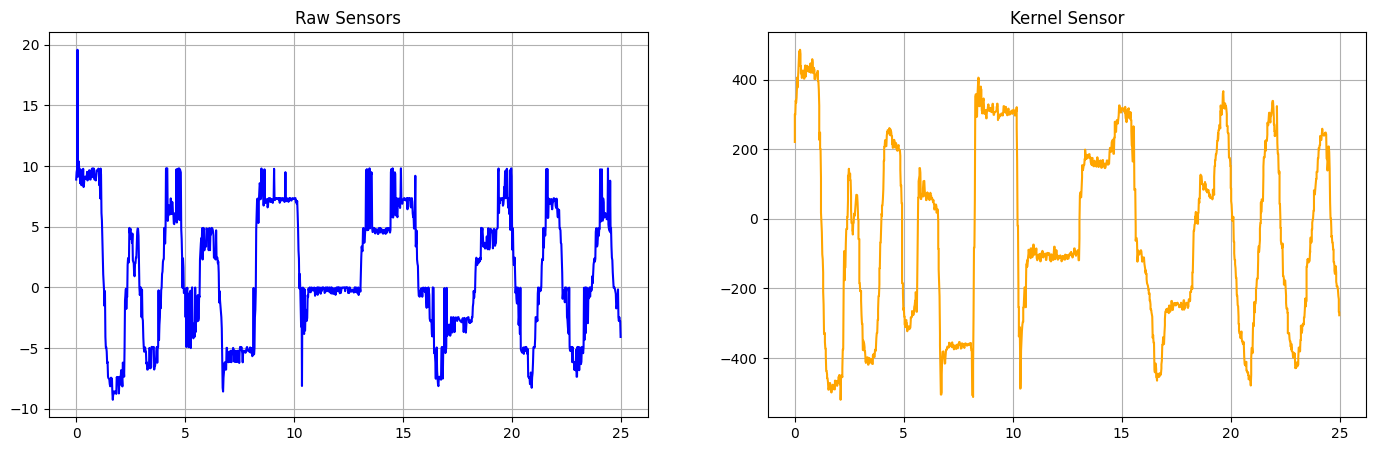

In [27]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(time, yTarget, color='blue')
plt.title('Raw Sensors')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time, yDesired, color='orange')
plt.title('Kernel Sensor')
plt.grid()

- Comparação normalizada com erro relacionado à distancia entre os pontos

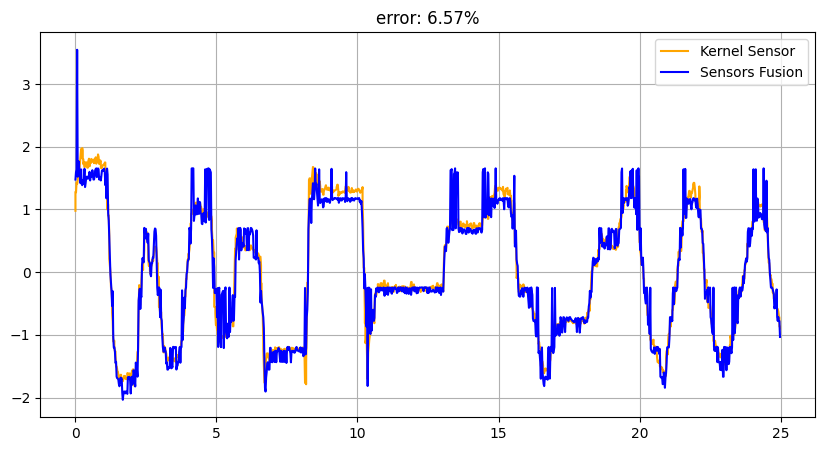

In [28]:
def normalize(data):
    return np.array(data - np.mean(data))/np.std(data)

def compare(data1, data2):
    data1 = normalize(data1)
    data2 = normalize(data2)
    score = wasserstein_distance(data1, data2)
    return data1, data2, score


d, t, score = compare(yDesired, yTarget)
plt.figure(figsize=(10, 5))
plt.plot(time, d, color='orange', label='Kernel Sensor')
plt.plot(time, t, color='blue',  label='Sensors Fusion')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()

# FILTRO DIGITAL

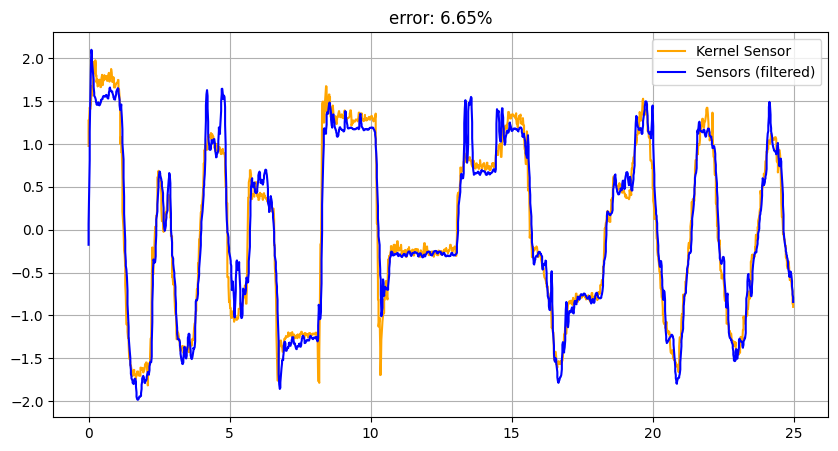

In [29]:
import math

class ButterworthFilter:
    def __init__(self, f_c):
        self.f_c = f_c / 2.0  
        self.b, self.a = self.coefs()
        self.Xn1 = self.Xn2 = 0.0
        self.Yn1 = self.Yn2 = 0.0

    def coefs(self):
        wc = math.tan(math.pi * self.f_c)
        c2 = wc*wc
        norm = 1 + math.sqrt(2)*wc + c2

        b0 = c2/norm
        b1 = 2*c2/norm
        b2 = c2/norm

        a1 = 2*(c2 - 1)/norm
        a2 = (1 - math.sqrt(2)*wc + c2)/norm
        return [b0, b1, b2], [1.0, -a1, -a2]

    def update(self, Xn):
        Yn = (
            self.b[0] * Xn +
            self.b[1] * self.Xn1 +
            self.b[2] * self.Xn2 +
            self.a[1] * self.Yn1 +
            self.a[2] * self.Yn2
        )
        self.Xn2, self.Xn1 = self.Xn1, Xn
        self.Yn2, self.Yn1 = self.Yn1, Yn
        return Yn
    
    def reset(self):
        self.Xn1 = self.Xn2 = 0.0
        self.Yn1 = self.Yn2 = 0.0
    
    def apply(self, data):
        self.reset()
        return [self.update(val) for val in data]


filter = ButterworthFilter(f_c=0.15)
d, t, score = compare(yDesired, filter.apply(yTarget))

plt.figure(figsize=(10, 5))
plt.plot(time, d, color='orange', label='Kernel Sensor')
plt.plot(time, t, color='blue',  label='Sensors (filtered)')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()

# COMPARAÇÕES

In [30]:
stored = {}

<Figure size 1700x1000 with 0 Axes>

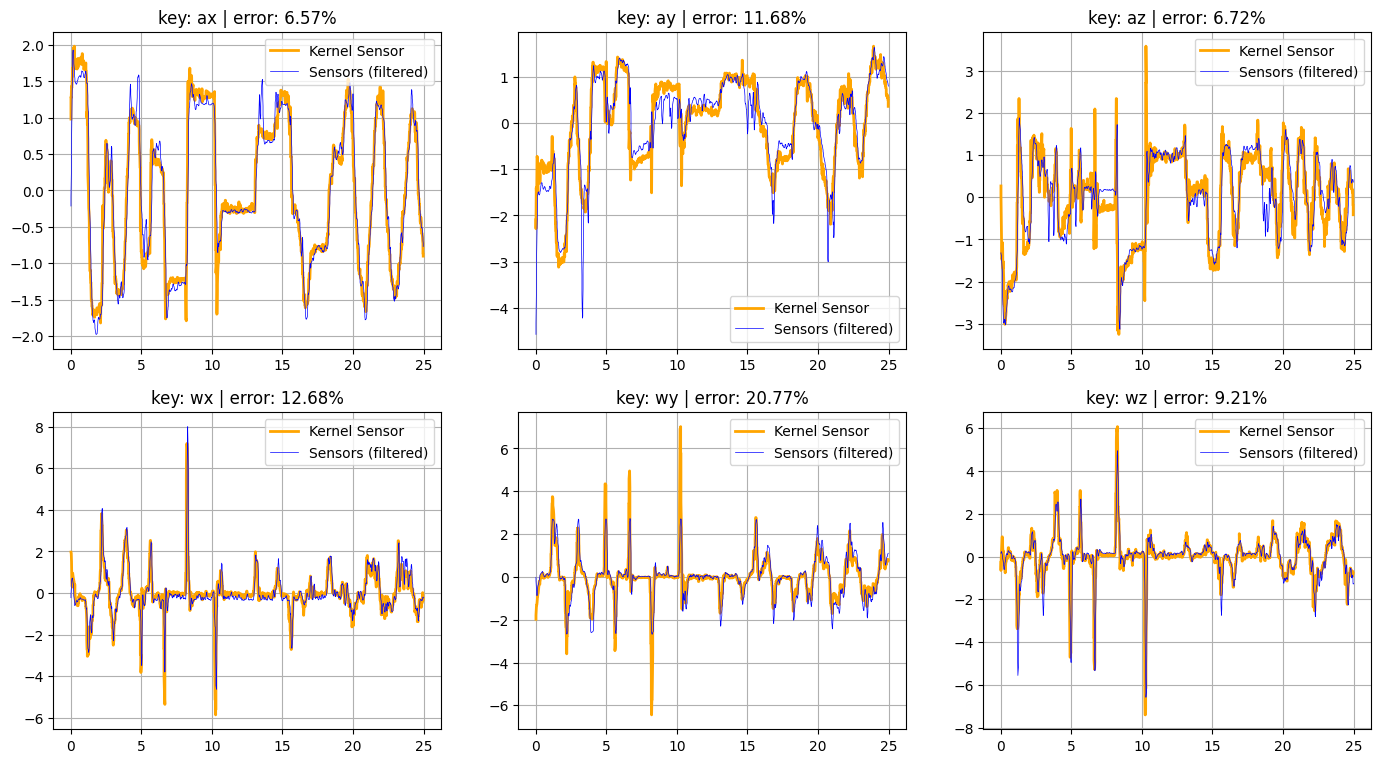

In [31]:
plt.figure(figsize=(17, 10))
sensor = 's1'
fc_accel = 0.10
fc_omega = 0.15

values = {
    'ax': ButterworthFilter(f_c=fc_accel).apply([s['ax'] for s in target[sensor]]),
    'ay': ButterworthFilter(f_c=fc_accel).apply([s['ay'] for s in target[sensor]]),
    'az': ButterworthFilter(f_c=fc_accel).apply([s['az'] for s in target[sensor]]),

    'wx': ButterworthFilter(f_c=fc_omega).apply([s['wx'] for s in target[sensor]]),
    'wy': ButterworthFilter(f_c=fc_omega).apply([s['wy'] for s in target[sensor]]),
    'wz': ButterworthFilter(f_c=fc_omega).apply([s['wz'] for s in target[sensor]]),
}

plt.figure(figsize=(17, 14))
stored[sensor] = values
index = 0

for key, data in values.items():
    d, t, score = compare(desired[key], data)
    index = index + 1

    plt.subplot(3, 3, index)
    plt.plot(desired.time, d, color='orange', label='Kernel Sensor', linewidth=2)
    plt.plot(desired.time, t, color='blue',  label='Sensors (filtered)', linewidth=.5)
    plt.title(f'key: {key} | error: {score*100:.2f}%')
    plt.legend(), plt.grid()

<Figure size 1700x1000 with 0 Axes>

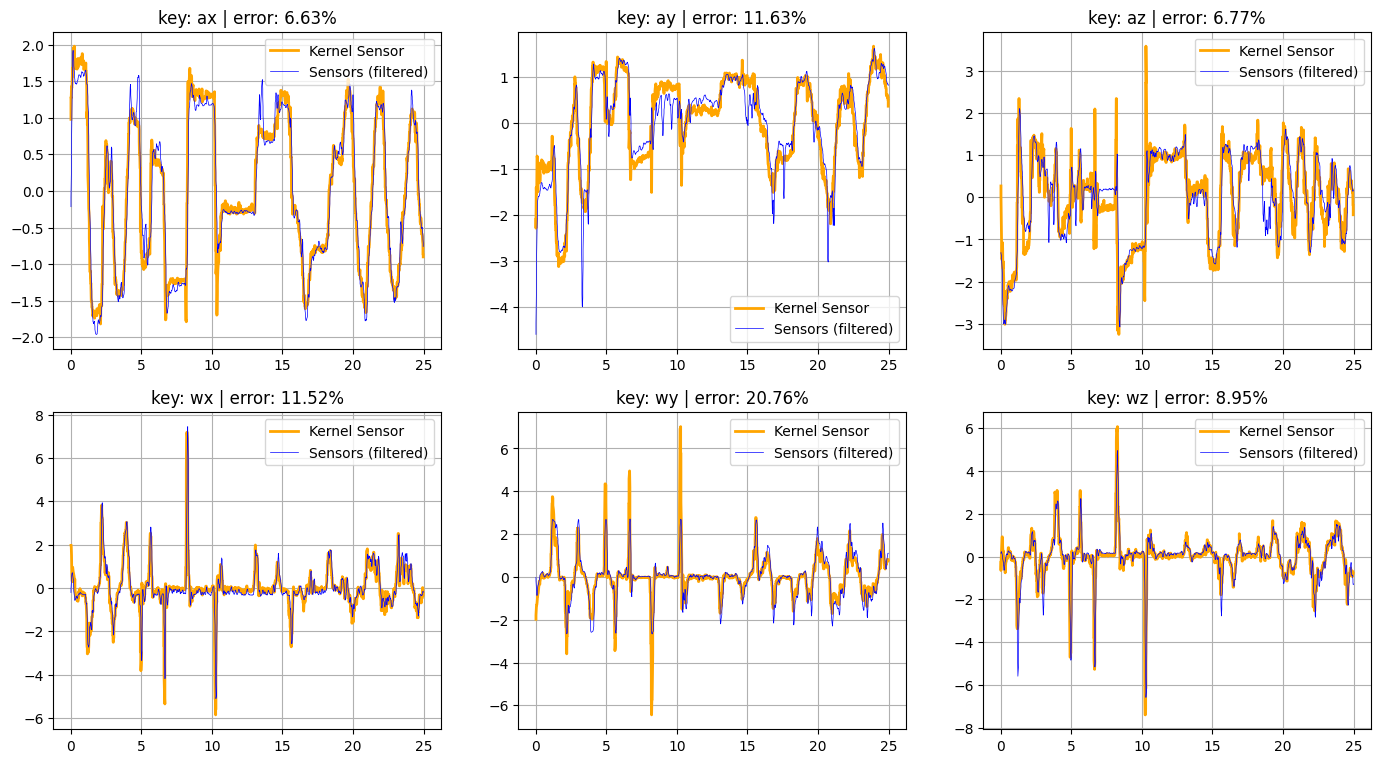

In [32]:
plt.figure(figsize=(17, 10))
sensor = 's2'
fc_accel = 0.10
fc_omega = 0.15

values = {
    'ax': ButterworthFilter(f_c=fc_accel).apply([s['ax'] for s in target[sensor]]),
    'ay': ButterworthFilter(f_c=fc_accel).apply([s['ay'] for s in target[sensor]]),
    'az': ButterworthFilter(f_c=fc_accel).apply([s['az'] for s in target[sensor]]),

    'wx': ButterworthFilter(f_c=fc_omega).apply([s['wx'] for s in target[sensor]]),
    'wy': ButterworthFilter(f_c=fc_omega).apply([s['wy'] for s in target[sensor]]),
    'wz': ButterworthFilter(f_c=fc_omega).apply([s['wz'] for s in target[sensor]]),
}

plt.figure(figsize=(17, 14))
stored[sensor] = values
index = 0

for key, data in values.items():
    d, t, score = compare(desired[key], data)
    index = index + 1

    plt.subplot(3, 3, index)
    plt.plot(desired.time, d, color='orange', label='Kernel Sensor', linewidth=2)
    plt.plot(desired.time, t, color='blue',  label='Sensors (filtered)', linewidth=.5)
    plt.title(f'key: {key} | error: {score*100:.2f}%')
    plt.legend(), plt.grid()

# SALVANDO

In [33]:
for i in range(len(target)):
    row = target.iloc[i]

    for sensor in stored.keys():
        for key in stored[sensor].keys():
            row[sensor][key] = stored[sensor][key][i]

target.head()

,time,s2,s1
790,0.00,"{'ax': 0.1783421941299244, 'ay': 0.09260905795...","{'ax': 0.1783421941299244, 'ay': 0.09260905795..."
791,0.00,"{'ax': 0.8134219711045458, 'ay': 0.42239158732...","{'ax': 0.8134219711045458, 'ay': 0.42239158732..."
792,0.02,"{'ax': 1.880247119104515, 'ay': 0.973287208666...","{'ax': 1.8811126117435046, 'ay': 0.97323912908..."
793,0.04,"{'ax': 3.1671693029767765, 'ay': 1.61861328550...","{'ax': 3.1693858251863367, 'ay': 1.61824975495..."
794,0.04,"{'ax': 4.515188667568089, 'ay': 2.257755268012...","{'ax': 4.516362568239357, 'ay': 2.256593591657..."


In [34]:
target.to_pickle('../C - Fusion/files/Target.pkl')
desired.to_pickle('../C - Fusion/files/Desired.pkl')